# <p align="center">XChem Data Collection, Filtering and Processing Pipeline</p>

## **Intro**

This notebook holds the narrative of steps taken, and outputs obtained to extract, filter and process the XChem data.

Chapters:

- [Access S3 Data](#s3data)
- [Create tools to explore S3 Data File System](#filesys)
- [Explore S3 Data File System Structure](#explores3)
- [Reorganise S3 Object Keys Files](#reorgfiles)
- [File System Overall Statistics](#s3stats)
- [Deep exploration of File System](#deepexploration)
- [Find and Migrate Paths of Interest](#findpaths)

In [ ]:
from pathlib import Path
import sys
sys.path.append( Path( "../.." ).resolve() )

<a id="s3data"></a>

---

## **Access S3 Data**


### <ins>Task</ins>: Initialize

In [ ]:
import os
from xaidar.s3Utils import decryptCredentials, initialize, listKeys, getBucketSize
from xaidar.filesUtils import loadPickle, countFiles

credKey = os.getenv( "CRED_KEY" ) 

credPath =  Path( "../../credentials.enc").resolve()
credDict = decryptCredentials( credKey, credPath )

client = initialize( "XChem" )

### <ins>Task</ins>: Extract all the Keys In All Buckets

Currently, there are two populated buckets in the S3 Object Store: "pandda" and "xchem". I am unsure about the origin of the former, with my unfounded guess being that it was created by the same person that extracted the "xchem" data from the magnetic tape archived data.

The keys for each bucket were saved in several pickle files, in order to prevent RAM exhaustion. At the same time, this allows to perform parallel tasks, with the each process working on a separate file.

In [ ]:
listKeys("pandda", client, saveDir = "PanDDa", fragSize=1e2, maxLen=None)
listKeys("xchem", client, saveDir = "XChem", fragSize=1e4, maxLen=None)

### <ins>Task</ins>: Count the Number of Keys Present in Each Bucket

This was performed in helios and the following results were obtained:

| Bucket | Number of Objects |
|:------:|:-----------------:|
|"xchem" | 129'663'921 |
|"pandda"| 5'115'714|

<br>

<details>
<summary>Raw output per pickle file:</summary>

-  XChem Bucket: 
    - [1001, 10'000'878, 10'000'001, 10'000'865, 10'000'984, 10'000'793, 10'000'748, 10'000'816, 10'000'001, 10'000'977, 10'000'001, 10'000'844, 10'000'837, 9'655'175]

-  PanDDa Bucket: 
    - [1001, 100746, 100296, 100449, 100200, 100839, 100593, 100764, 100142, 100144, 100620, 100295, 100318, 100582, 100497, 100415, 100704, 100555, 100780, 100052, 100431, 100651, 100152, 100941, 100463, 100092, 100744, 100720, 100648, 100279, 100081, 100013, 100375, 100119, 100191, 100928, 100688, 100254, 100860, 100648, 100434, 100534, 100337, 100552, 100906, 100843, 100141, 100668, 100010, 100331, 100408, 91280]
</detail>

In [ ]:
print( countFiles( "PanDDa", filesLst = [f"frag{n+1}.pkl" for n in range( len( list( os.listdir( "PanDDa" ) ) ) ) ] ) )
print( countFiles("XChem", filesLst = [f"frag{n+1}.pkl" for n in range(14) ] ) )

<a id="filesys"></a>

---

## **Create tools to explore S3 Data File System**


<a id='FileSys'></a>

### <ins>Task</ins>: Create a Nested List Structure

In [8]:
# helios
lstObjectKeys = loadPickle( os.path.join( "output", "ObjectStore", "XChem", "frag1.pkl" ) )

# # local
# lstObjectKeys = loadPickle( os.path.join( "sandbox", "Boto3", "XChemFiles", "frag1.pkl" ) )

lstObjectKeys = lstObjectKeys[:100000]
# print(lstObjectKeys[:5])
# lstObjectKeys = testTree
fileTree, folderTree, folderTreeMaxDepth,  foldersIDS, foldersCount, foldersLst = createTree( lstObjectKeys )

### <ins>Task</ins>: View File System Structure

In [20]:
# viewTree( fileTree, folderTreeMaxDepth + 1, foldersCount, viewFiles = True)
folderID =  [ 0, 0, 0, 0, 0] # first element represent the root 
folderPath = None #  "data/2015/lb13308-1/processing/old_processing_prior_to_20160520"
viewSubtree( fileTree,  foldersCount, len( folderID ) , len( folderID ) +  5,  
            folderID = folderID ,
            folderPath = None,
            viewFiles = True, getFileIDS = False, getFilePathS = False )

folderID =  [ 0, 0, 0, 0, 0] 
viewSubtree( fileTree,  foldersCount, len( folderID ) , len( folderID ) +  5,  
            folderID = folderID ,
            folderPath = None,
            viewFiles = True, getFileIDS = False, getFilePathS = False )

old_processing_prior_to_20160520
└── analysis
    └── dimple-maps
        └── KRASQ61
            └── KRASQ61-x56
old_processing_prior_to_20160520
└── analysis
    └── dimple-maps
        └── KRASQ61
            └── KRASQ61-x56


In [ ]:
viewTree( fileTree, folderTreeMaxDepth - 8, foldersCount, viewFiles = True)

data
└── 2015
    ├── lb13308-1
    │   └── processing
    │       ├── old_processing_prior_to_20160520
    │       ├── reference
    │       └── transfer_pandda_data.done
    ├── lb13308-2
    │   └── processing
    │       └── README.reprocessing
    └── lb13320-1
        └── processing
            ├── AR_compounds_pdb
            ├── TeXRank
            ├── allDatasets
            ├── analysis
            ├── 2018072014.txt
            ├── 2018072014.txt.info.csv
            ├── 2018081517.txt
            ├── 2018081517.txt.info.csv
            ├── 2019100110.txt
            ├── 2019100110.txt.info.csv
            ├── README.reprocessing
            ├── STDIN.e18931570
            ├── STDIN.o18931570
            └── XChemExplorer_settings.pkl


In [ ]:
viewLstPathS(lstObjectKeys, maxlevel = 6)

root
└── data
    └── 2015
        ├── lb13308-1
        │   └── processing
        │       ├── old_processing_prior_to_20160520
        │       ├── reference
        │       └── transfer_pandda_data.done
        ├── lb13308-2
        │   └── processing
        │       └── README.reprocessing
        └── lb13320-1
            └── processing
                ├── 2018072014.txt
                ├── 2018072014.txt.info.csv
                ├── 2018081517.txt
                ├── 2018081517.txt.info.csv
                ├── 2019100110.txt
                ├── 2019100110.txt.info.csv
                ├── AR_compounds_pdb
                ├── README.reprocessing
                ├── STDIN.e18931570
                ├── STDIN.o18931570
                ├── TeXRank
                ├── XChemExplorer_settings.pkl
                ├── allDatasets
                └── analysis


<details>
<summary>Notes on Updates:</summary>

To do In the future:
- Allow to open several folder IDs at the same time
    - Easy solution: just run viewSubtree for each folderID
- Allow to open based on path
</details>


### <ins>Task</ins>: Walk through the file system

In [ ]:
# # Use Folder ID
# openFolder( fileTree, foldersCount, [0, 0, 0, 0, ] )

# Use Folder Path or Folder Name w Depth
openFolderwPath( fileTree, foldersCount, "data/2015/lb13320-1/processing" )


['AR_compounds_pdb',
 'TeXRank',
 'allDatasets',
 'analysis',
 '2018072014.txt',
 '2018072014.txt.info.csv',
 '2018081517.txt',
 '2018081517.txt.info.csv',
 '2019100110.txt',
 '2019100110.txt.info.csv',
 'README.reprocessing',
 'STDIN.e18931570',
 'STDIN.o18931570',
 'XChemExplorer_settings.pkl']

In [ ]:
print( openFolder( fileTree, foldersCount, [0,0, 1, 0] ) )
print( openFolderwPath( fileTree, foldersCount, "data/2015/lb13308-1/processing" ) )# lb13308-1', 'lb13308-2', 'lb13320-1
print( openFolderwPath( fileTree, foldersCount, "data/2015/lb13308-2" ) )# lb13308-1', 'lb13308-2', 'lb13320-1
print( openFolderwPath( fileTree, foldersCount, "data/2015/lb13320-1/processing" ) )# lb13308-1', 'lb13308-2', 'lb13320-1

['README.reprocessing']
['AR_compounds_pdb', 'TeXRank', 'allDatasets', 'analysis', '2018072014.txt', '2018072014.txt.info.csv', '2018081517.txt', '2018081517.txt.info.csv', '2019100110.txt', '2019100110.txt.info.csv', 'README.reprocessing', 'STDIN.e18931570', 'STDIN.o18931570', 'XChemExplorer_settings.pkl']
['processing']
['AR_compounds_pdb', 'TeXRank', 'allDatasets', 'analysis', '2018072014.txt', '2018072014.txt.info.csv', '2018081517.txt', '2018081517.txt.info.csv', '2019100110.txt', '2019100110.txt.info.csv', 'README.reprocessing', 'STDIN.e18931570', 'STDIN.o18931570', 'XChemExplorer_settings.pkl']


<details>
<summary>Notes on Updates:</summary>

- Add typo checker to make sure there are no mistakes occuring

</details>

### <ins>Task</ins>: Filter all the file types existent

In [ ]:
filteredFiles, failedFiles = getFileTypes( lstObjectKeys, regexFilterS = [ ["not", "[0-9][0-9][0-9][0-9]$"] ] )
numFiles = 12
for idx in range(  ( len(list( filteredFiles.values())[-1]  ) // numFiles) + 1 ):
    print( list( filteredFiles.values())[-1][idx*numFiles: (idx+1)*numFiles ] )

['.HKL', '.INP', '.LP', '.XDS', '.bak', '.bib', '.cbf', '.ccp4', '.cif', '.csh', '.csv', '.dat']
['.dc_id', '.debug', '.done', '.eff', '.epr', '.err', '.error', '.exe', '.gz', '.html', '.jar', '.jpg']
['.json', '.log', '.map', '.mol', '.mtz', '.out', '.params', '.pck', '.pdb', '.phil', '.pickle', '.pkl']
['.pml', '.png', '.py', '.r3d', '.reprocessing', '.rst', '.running', '.sca', '.scm', '.sh', '.smi', '.smiles']
['.sol', '.sqlite', '.sum', '.txt', '.xinfo', '.xlsm', '.xml']


In [ ]:
filesofInterest = [".mtz", ".ccp4", ".pdb", ".smiles", ".cif", ".sqlite" ]

<a id="explores3"> </a>

---

## **Explore S3 Data File System Structure**



### <ins>Task</ins>: Look at directory structure of XChem and PanDDA Buckets

<details open>
<summary>Notes:</summary>

- PanDDa Bucket:
    
    - It does not contain a root. The supraroot contains a list of files - describing records and log files - and each folder represents a specific project.
    - This PanDDA Bucket seems to be associated with the XChem bucket - dataset directory.

- XChem Bucket:
    - It contains 2 main root directories: "data", "dataset".
        - Dataset: It seems to be associated with processing the data afterwards
            - There is no PanDDa data included in this directory.
        - Data: Original data. There are two main project structes: *\<year>-\<projectID-subprojID>* and *\<projID>-\<subprojID>*
            - Each project contains PanDDa data.
            

</details>


- Get File Paths

In [5]:
# getFragFiles() : -> paths, filesDict
import os
from scripts.filesUtils import getFragFiles

# Initialize Directory Path

# # Local
# xchemPath = os.path.join( "D:", "Documents", "XAIDA", "output", "ObjectStore", "XChem")
# panddaPath = os.path.join( "D:", "Documents", "XAIDA", "output", "ObjectStore", "PanDDa")

# Helios
xchemPath = os.path.join( "output", "ObjectStore", "XChem")
panddaPath = os.path.join( "output", "ObjectStore", "PanDDa")

paths = [xchemPath, panddaPath]

# Get Directories Files Sorted by Name ("fragX.pkl")
filesDict = getFragFiles( paths )

XChem
['frag1.pkl', 'frag2.pkl', 'frag3.pkl', 'frag4.pkl', 'frag5.pkl', 'frag6.pkl', 'frag7.pkl', 'frag8.pkl', 'frag9.pkl', 'frag10.pkl', 'frag11.pkl', 'frag12.pkl', 'frag13.pkl', 'frag14.pkl']
PanDDa
['frag1.pkl', 'frag2.pkl', 'frag3.pkl', 'frag4.pkl', 'frag5.pkl', 'frag6.pkl', 'frag7.pkl', 'frag8.pkl', 'frag9.pkl', 'frag10.pkl', 'frag11.pkl', 'frag12.pkl', 'frag13.pkl', 'frag14.pkl', 'frag15.pkl', 'frag16.pkl', 'frag17.pkl', 'frag18.pkl', 'frag19.pkl', 'frag20.pkl', 'frag21.pkl', 'frag22.pkl', 'frag23.pkl', 'frag24.pkl', 'frag25.pkl', 'frag26.pkl', 'frag27.pkl', 'frag28.pkl', 'frag29.pkl', 'frag30.pkl', 'frag31.pkl', 'frag32.pkl', 'frag33.pkl', 'frag34.pkl', 'frag35.pkl', 'frag36.pkl', 'frag37.pkl', 'frag38.pkl', 'frag39.pkl', 'frag40.pkl', 'frag41.pkl', 'frag42.pkl', 'frag43.pkl', 'frag44.pkl', 'frag45.pkl', 'frag46.pkl', 'frag47.pkl', 'frag48.pkl', 'frag49.pkl', 'frag50.pkl', 'frag51.pkl', 'frag52.pkl']


- Iteratively Look at each file content

In [2]:
# Initialize variable to be able to go through different Pickle Files

from scripts.filesUtils import loadPickle
from scripts.objFileSys import createTree, viewSubtree, pinchLevel

nextPklfile = 0

In [ ]:
# Run cell several times to jump from frag_n.pkl to frag_n+1.pkl tree

# Check PanDDa Bucket
lstOfPathS = loadPickle( os.path.join( panddaPath, filesDict["PanDDa"][ nextPklfile ] ) )[1:]

# # Check XChem Bucket
# lstOfPathS = loadPickle( os.path.join( xchemPath,filesDict["XChem"][ nextPklfile ] ) )[1:]

print( f"Number of Files: {len( lstOfPathS)}\nFirst 5 Paths: \t{lstOfPathS[:5]}")
print(f"\nCurrently looking at content of file number: {nextPklfile + 1}")
fileTree, folderTree, folderTreeMaxDepth,  foldersIDS, foldersCount, foldersLst = createTree( lstOfPathS )
nextPklfile += 1

In [ ]:
# Root folders Names
print( pinchLevel( fileTree, 1 ) )

In [ ]:
# Interactively look at the folders tree
folderID = [0]
viewSubtree( fileTree, foldersCount, 1,  len( folderID) + 3, folderID = folderID, 
            viewFiles = True, getFileIDS = False )

### <ins>Task</ins>: List Names of all Root Directories And Subdirectories

In [2]:
# Get Roots Names # Takes aroudn 2.5 minutes
from scripts.filesUtils import loadPickle, getRootFolders
rootSDict = getRootFolders( paths, filesDict)


XChem 

Finished frag1.pkl
Finished frag2.pkl
Finished frag3.pkl
Finished frag4.pkl
Finished frag5.pkl
Finished frag6.pkl
Finished frag7.pkl
Finished frag8.pkl
Finished frag9.pkl
Finished frag10.pkl
Finished frag11.pkl
Finished frag12.pkl
Finished frag13.pkl
Finished frag14.pkl
['data', 'dataset']
PanDDa 

Finished frag1.pkl
Finished frag2.pkl
Finished frag3.pkl
Finished frag4.pkl
Finished frag5.pkl
Finished frag6.pkl
Finished frag7.pkl
Finished frag8.pkl
Finished frag9.pkl
Finished frag10.pkl
Finished frag11.pkl
Finished frag12.pkl
Finished frag13.pkl
Finished frag14.pkl
Finished frag15.pkl
Finished frag16.pkl
Finished frag17.pkl
Finished frag18.pkl
Finished frag19.pkl
Finished frag20.pkl
Finished frag21.pkl
Finished frag22.pkl
Finished frag23.pkl
Finished frag24.pkl
Finished frag25.pkl
Finished frag26.pkl
Finished frag27.pkl
Finished frag28.pkl
Finished frag29.pkl
Finished frag30.pkl
Finished frag31.pkl
Finished frag32.pkl
Finished frag33.pkl
Finished frag34.pkl
Finished frag35.pkl
F

In [16]:
# Output Roots Names
print("Bucket: List of Root Folders")
for bucket in rootSDict.keys(): print( f"{bucket}: {rootSDict[ bucket ]}")
# PanDDa Root Folders
import re
print("Filtered PanDDa: ", [ rootFolder for rootFolder in rootSDict["PanDDa"] if not re.match(".*\\..*", rootFolder)] )

Bucket: List of Root Folders
XChem: ['data', 'dataset']
PanDDa: ['70X', '70X.err', '70X.log', '70X.out', '70X.sh', '70X.singularity.sh', 'AAVNAR', 'AAVNAR.err', 'AAVNAR.log', 'AAVNAR.out', 'AAVNAR.sh', 'AAVNAR.singularity.sh', 'AA_VNAR_XF01', 'AA_VNAR_XF01.err', 'AA_VNAR_XF01.log', 'AA_VNAR_XF01.out', 'AA_VNAR_XF01.sh', 'AA_VNAR_XF01.singularity.sh', 'ACVR1A', 'ACVR1A.err', 'ACVR1A.log', 'ACVR1A.out', 'ACVR1A.sh', 'ACVR1A.singularity.sh', 'ATAD2A', 'ATAD2A.err', 'ATAD2A.log', 'ATAD2A.out', 'ATAD2A.sh', 'ATAD2A.singularity.sh', 'B2m', 'B2m.err', 'B2m.log', 'B2m.out', 'B2m.sh', 'B2m.singularity.sh', 'BKVP1', 'BKVP1.err', 'BKVP1.log', 'BKVP1.out', 'BKVP1.sh', 'BKVP1.singularity.sh', 'BKVP126', 'BKVP126.err', 'BKVP126.log', 'BKVP126.out', 'BKVP126.sh', 'BKVP126.singularity.sh', 'BRD1', 'BRD1.err', 'BRD1.log', 'BRD1.out', 'BRD1.sh', 'BRD1.singularity.sh', 'CD44MMA', 'CD44MMA.err', 'CD44MMA.log', 'CD44MMA.out', 'CD44MMA.sh', 'CD44MMA.singularity.sh', 'CD73', 'CD73.err', 'CD73.log', 'CD73.out

In [ ]:
# Check PanDDa first object keys
lstOfPathS = loadPickle( os.path.join( panddaPath, "frag1.pkl" ) )[1:]
print(lstOfPathS[:5])

['70X.err', '70X.log', '70X.out', '70X.sh', '70X.singularity.sh']


<a id="reorgfiles"></a>

---

## Reorganise S3 Object Key Files


### <ins>Task</ins>: Split data based on project

- XChem

In [ ]:
# Split the loaded Object Key Pickle Files By Project / Session (Must create saving directories beforehand)

import os
from scripts.filesUtils import splitXChemData

# # Local
# xchemPath = os.path.join( "D:", "Documents", "XAIDA", "output", "ObjectStore", "XChem")


# Helios
xchemPath = os.path.join( "output", "ObjectStore", "XChem")

splitXChemData( xchemPath, savedFolder = [  "output", "ObjectStore", "XChem", "PerProj"] )

['frag1.pkl', 'frag2.pkl', 'frag3.pkl', 'frag4.pkl', 'frag5.pkl', 'frag6.pkl', 'frag7.pkl', 'frag8.pkl', 'frag9.pkl', 'frag10.pkl', 'frag11.pkl', 'frag12.pkl', 'frag13.pkl', 'frag14.pkl']
File Name: frag1.pkl
File Name: frag2.pkl
Saved!
	Project: 2015_lb13308-1
Saved!
	Project: 2015_lb13308-2
Saved!
	Project: 2015_lb13320-1
Saved!
	Project: 2015_lb13320-12
Saved!
	Project: 2015_lb13320-3
Saved!
	Project: 2015_lb13320-5
Saved!
	Project: 2015_lb13320-8
File Name: frag3.pkl
File Name: frag4.pkl
Saved!
	Project: 2015_lb13379-1
Saved!
	Project: 2015_lb13380-1
Saved!
	Project: 2015_lb13381-1
Saved!
	Project: 2015_lb13385-1
Saved!
	Project: 2015_lb13385-13
Saved!
	Project: 2015_lb13385-2
Saved!
	Project: 2015_lb13385-21
Saved!
	Project: 2015_lb14320-1
Saved!
	Project: 2015_lb14320-5
Saved!
	Project: 2015_lb14321-1
Saved!
	Project: 2015_lb14321-2
Saved!
	Project: 2016_lb13320-14
Saved!
	Project: 2016_lb13320-16
Saved!
	Project: 2016_lb13385-25
Saved!
	Project: 2016_lb13385-30
Saved!
	Project: 

- PanDDA


In [ ]:
import os
from scripts.filesUtils import splitPanDDaData

# # Local
# xchemPath = os.path.join( "D:", "Documents", "XAIDA", "output", "ObjectStore", "XChem")

# Helios
panddaPath = os.path.join( "output", "ObjectStore", "PanDDa")

splitPanDDaData( xchemPath, savedFolder = [   "output", "ObjectStore", "PanDDa", "PerProj"] )

['frag1.pkl', 'frag2.pkl', 'frag3.pkl', 'frag4.pkl', 'frag5.pkl', 'frag6.pkl', 'frag7.pkl', 'frag8.pkl', 'frag9.pkl', 'frag10.pkl', 'frag11.pkl', 'frag12.pkl', 'frag13.pkl', 'frag14.pkl', 'frag15.pkl', 'frag16.pkl', 'frag17.pkl', 'frag18.pkl', 'frag19.pkl', 'frag20.pkl', 'frag21.pkl', 'frag22.pkl', 'frag23.pkl', 'frag24.pkl', 'frag25.pkl', 'frag26.pkl', 'frag27.pkl', 'frag28.pkl', 'frag29.pkl', 'frag30.pkl', 'frag31.pkl', 'frag32.pkl', 'frag33.pkl', 'frag34.pkl', 'frag35.pkl', 'frag36.pkl', 'frag37.pkl', 'frag38.pkl', 'frag39.pkl', 'frag40.pkl', 'frag41.pkl', 'frag42.pkl', 'frag43.pkl', 'frag44.pkl', 'frag45.pkl', 'frag46.pkl', 'frag47.pkl', 'frag48.pkl', 'frag49.pkl', 'frag50.pkl', 'frag51.pkl', 'frag52.pkl']
Saved!
	Project: 70X
Saved!
	Project: AAVNAR
Saved!
	Project: AA_VNAR_XF01
Saved!
	Project: ACVR1A
Saved!
	Project: ATAD2A
Saved!
	Project: B2m
Saved!
	Project: BKVP1
Saved!
	Project: BKVP126
Saved!
	Project: BRD1
Saved!
	Project: CD44MMA
Saved!
	Project: CD73
Saved!
	Project: CD

### <ins>Task</ins>: Create Trees For Files

In [ ]:
import os
from scripts.filesUtils import convertPathstoTree

# Helios
pklDir = os.path.join( "output", "ObjectStore", "XChem", "PerProj", "data")
saveDir = os.path.join( "output", "ObjectStore", "XChem", "PerProj", "data", "tree")

convertPathstoTree( pklDir , saveDir )

data
['2015_lb13308-1', '2015_lb13308-2', '2015_lb13320-1', '2015_lb13320-12', '2015_lb13320-3', '2015_lb13320-5', '2015_lb13320-8', '2015_lb13379-1', '2015_lb13380-1', '2015_lb13381-1', '2015_lb13385-1', '2015_lb13385-13', '2015_lb13385-2', '2015_lb13385-21', '2015_lb14320-1', '2015_lb14320-5', '2015_lb14321-1', '2015_lb14321-2', '2016_lb13320-14', '2016_lb13320-16', '2016_lb13385-25', '2016_lb13385-30', '2016_lb13385-31', '2016_lb13385-35', '2016_lb13385-36', '2016_lb13385-39', '2016_lb13385-40', '2016_lb13385-44', '2016_lb13385-46', '2016_lb13385-50', '2016_lb13385-52', '2016_lb13385-53', '2016_lb13385-54', '2016_lb13385-55', '2016_lb13385-56', '2016_lb13385-57', '2016_lb13385-58', '2016_lb13385-59', '2016_lb13385-61', '2016_lb13385-62', '2016_lb13385-63', '2016_lb13385-64', '2016_lb13385-65', '2016_lb13385-66', '2016_lb13385-67', '2016_lb13385-68', '2016_lb13385-69', '2016_lb13385-70', '2016_lb13385-71', '2016_lb13385-75', '2016_lb13385-76', '2016_lb13385-77', '2016_lb13385-78', '2

<a id="s3stats"> </a>

---

## File System Overall Statistics

**XChem Data**

<!--[ Number of Structural Files | ]: #-->

Overall
| Number Of Sessions | Number of Years | Number of Files | 
| :----: |:---: | :---: |  
| 738 | 9 (2015-23) | 129 302 508 |  

Per Year
| Years | Number Of Sessions | Number of Files | 
| :----: |:---: | :---: |
| 2015 | 18 | 24 732 821  |
| 2016 | 72 | 32 432 198 |
| 2017 | 159 |  25 736 567 |
| 2018 | 135 | 15 224 629 |
| 2019 | 111 | 6 401 530 |
| 2020 | 122 | 12 278 697 |
| 2021 | 83 | 10 561 631 |
| 2022 | 9 | 416 678 |
| ?2023? | 29 | 1 517 757 |

Per Session
| Min | Max | Average | Median | Standard Deviation | First Quartile | Third Quartile|
| :----: |:---: | :---: | :----: | :----: | :----: | :----: |
| 1 | 20 384 759 | 175 208 | 6.5 | 1 161 690 | 1 |  44 269.8 |

Notes:

Number of Sessions with 1 File only: 340 (out of 738 )


### <ins>Task</ins>: Get Names and Total Number of Projects

In [3]:
import os
import re
from collections import defaultdict
from scripts.filesUtils import saveList, loadPickle

# Local
dataPath = os.path.join( "D:", "Documents", "XAIDA", "output", "ObjectStore", "XChem", "PerProj","data")
# datasetPath = os.path.join( "D:", "Documents", "XAIDA", "output", "ObjectStore", "XChem", "PerProj","dataset")

# # Helios
# dataPath = os.path.join( "output", "ObjectStore", "XChem", "PerProj", "data")
# datasetPath = os.path.join( "output", "ObjectStore", "XChem", "PerProj","dataset")

# Get Pickle File Names 
filesLst = []
for content in os.listdir( dataPath):
    if os.path.isfile( os.path.join( dataPath, content) ): filesLst.append( content )
filesLst.sort()
print( "Files List", filesLst)
print( f"Number of total SubProjects: {len( filesLst) }\n")


oldProjS = [( proj.split("_")[0], proj.split("_")[1] ) for proj in filesLst if re.match(  "^[0-9][0-9][0-9][0-9]_", proj ) ] # "^[0-9][0-9][0-9][0-9]_"
repeatedYears = [file[0] for file in oldProjS ] 
years = sorted( list( set( repeatedYears ) ))
print(f"List of Years: {years}\nNumber of yeas: {len(years) + 1}")

lastYearProj = [( proj.split("_")[0], proj.split("_")[1] ) for proj in filesLst if re.match(  "^lb[0-9]+_lb[0-9]+-[0-9]+.pkl$", proj ) ] # "^lb[0-9]+_lb[0-9]+-[0-9]+$"

print("\nYear : SubProjs Count" )
for year in years:
    print(year,":",repeatedYears.count( year) )

print("2023 :", len( lastYearProj ) )

projectsCountDict = defaultdict( list )

# print(oldProjS, "\n", lastYearProj)


Files List ['2015_lb13308-1.pkl', '2015_lb13308-2.pkl', '2015_lb13320-1.pkl', '2015_lb13320-12.pkl', '2015_lb13320-3.pkl', '2015_lb13320-5.pkl', '2015_lb13320-8.pkl', '2015_lb13379-1.pkl', '2015_lb13380-1.pkl', '2015_lb13381-1.pkl', '2015_lb13385-1.pkl', '2015_lb13385-13.pkl', '2015_lb13385-2.pkl', '2015_lb13385-21.pkl', '2015_lb14320-1.pkl', '2015_lb14320-5.pkl', '2015_lb14321-1.pkl', '2015_lb14321-2.pkl', '2016_lb13320-14.pkl', '2016_lb13320-16.pkl', '2016_lb13385-25.pkl', '2016_lb13385-30.pkl', '2016_lb13385-31.pkl', '2016_lb13385-35.pkl', '2016_lb13385-36.pkl', '2016_lb13385-39.pkl', '2016_lb13385-40.pkl', '2016_lb13385-44.pkl', '2016_lb13385-46.pkl', '2016_lb13385-50.pkl', '2016_lb13385-52.pkl', '2016_lb13385-53.pkl', '2016_lb13385-54.pkl', '2016_lb13385-55.pkl', '2016_lb13385-56.pkl', '2016_lb13385-57.pkl', '2016_lb13385-58.pkl', '2016_lb13385-59.pkl', '2016_lb13385-61.pkl', '2016_lb13385-62.pkl', '2016_lb13385-63.pkl', '2016_lb13385-64.pkl', '2016_lb13385-65.pkl', '2016_lb13385-

### <ins>Task</ins>: Get count of number of Files Per Project

In [4]:
from collections import defaultdict
oldProjSLst = [ proj for proj in filesLst if re.match(  "^[0-9][0-9][0-9][0-9]_", proj ) ] # 
lastYearProj = [ proj for proj in filesLst if re.match(  "^lb[0-9]+_lb[0-9]+-[0-9]+$", proj ) ] 

totalFileCount = 0
perYearFileCount = defaultdict( int )
perProjFileCount = []

for pklFile in oldProjSLst:
    lstPathS = loadPickle( os.path.join( dataPath, pklFile) )

    pathsNumber = len( lstPathS )

    totalFileCount += pathsNumber

    perYearFileCount[ pklFile[:4] ] += pathsNumber

    perProjFileCount.append( pathsNumber )


for pklFile in lastYearProj:
    lstPathS = loadPickle( os.path.join( dataPath, pklFile) )

    pathsNumber = len( lstPathS )

    totalFileCount += pathsNumber

    perYearFileCount[ 2023 ] += pathsNumber

    perProjFileCount.append( pathsNumber )

print(f"Total File Count: {totalFileCount} \nNumberOfProjcets: {len( perProjFileCount )}\n" )
print("Year : Files Count")
for year in perYearFileCount.keys(): print( year, perYearFileCount[year])

Total File Count: 127785459 
NumberOfProjcets: 709

Year : Files Count
2015 24732838
2016 32432270
2017 25736726
2018 15224764
2019 6401641
2020 12278819
2021 10561714
2022 416687


In [5]:
import numpy as np
print("Per Project File Count Statistics")
print(f"Min: { min(perProjFileCount) }")
print(f"Max: { max(perProjFileCount) }")
print( f"Mean: {round( np.mean( np.array( perProjFileCount) ), 0 ) }")
print( f"Median: {round( np.median( np.array( perProjFileCount) ), 2) }")
print( f"First Quartile: { round( np.quantile( np.array(perProjFileCount ), 0.25 ), 1 )}\tThird Quartile: {round( np.quantile( np.array(perProjFileCount ), 0.75 ), 1 )}")
print( f"Standard Deviation: {round( np.std( np.array( perProjFileCount) ), 0 ) }")


Per Project File Count Statistics
Min: 1
Max: 20384759
Mean: 175208.0
Median: 6.5
First Quartile: 1.0	Third Quartile: 44269.8
Standard Deviation: 1161690.0


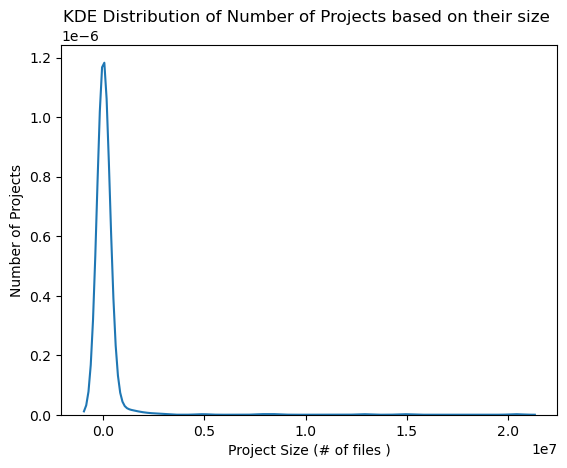

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.kdeplot( perProjFileCount)
plt.xlabel("Project Size (# of files )")
plt.ylabel( "Number of Projects")
plt.title( "KDE Distribution of Number of Projects based on their size ")
plt.show()

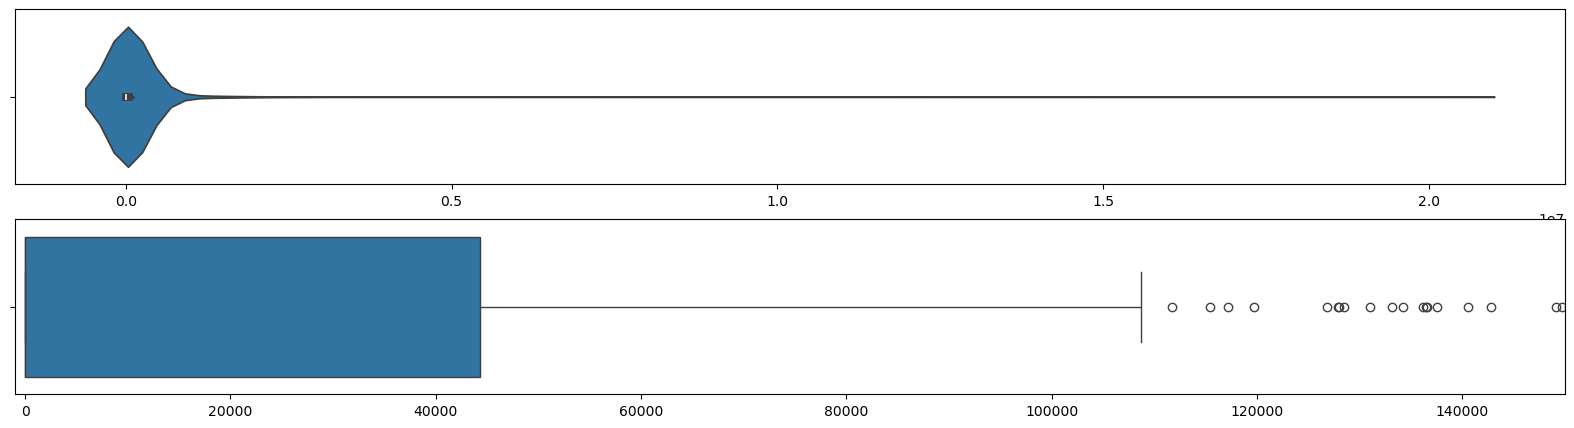

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# plt.figure( figsize = [20 , 5] )

fig, axis = plt.subplots( 2, 1, figsize = [ 20, 5] )
sns.violinplot( perProjFileCount, ax = axis[0], orient = "h")
sns.boxplot( perProjFileCount, ax = axis[1], orient = "h")
axis[1].set_xlim( -1e3, 1e5+5e4)
plt.show()

### <ins>Task</ins>: Find out why so many one counts

In [28]:
print( perProjFileCount.count(  1 ) )

340


In [ ]:
onesIdxs = [ idx for idx, count in enumerate( perProjFileCount) if count == 1]
print(f"Indexes of Projs with one File: {onesIdxs}" )
lstOfProjs =  oldProjSLst + lastYearProj
onesProjs = [ lstOfProjs[idx] for idx in onesIdxs ]
print( f"Name of Projs with one Files: {onesProjs}" )

Indexes of Projs with one File: [1, 15, 30, 34, 36, 49, 50, 51, 52, 53, 57, 59, 62, 63, 65, 66, 67, 68, 69, 71, 72, 74, 77, 78, 79, 80, 81, 82, 83, 85, 87, 89, 94, 102, 103, 104, 105, 106, 107, 108, 109, 110, 115, 117, 118, 125, 126, 127, 128, 129, 130, 131, 132, 134, 136, 139, 141, 145, 146, 147, 148, 156, 159, 161, 163, 164, 165, 169, 170, 172, 173, 174, 176, 178, 179, 180, 183, 184, 186, 190, 192, 194, 195, 197, 199, 200, 205, 206, 207, 209, 210, 212, 214, 218, 219, 220, 224, 225, 228, 233, 237, 240, 244, 245, 246, 247, 248, 251, 253, 254, 255, 256, 257, 259, 260, 261, 262, 264, 265, 267, 269, 270, 271, 276, 277, 278, 279, 282, 288, 289, 290, 292, 295, 296, 297, 298, 299, 300, 302, 303, 305, 306, 307, 308, 309, 311, 313, 315, 316, 317, 320, 322, 324, 325, 327, 328, 330, 332, 334, 336, 337, 338, 339, 340, 342, 343, 344, 345, 346, 347, 348, 350, 351, 354, 355, 358, 360, 362, 369, 371, 373, 376, 377, 378, 379, 380, 382, 384, 385, 387, 388, 389, 391, 392, 393, 394, 396, 399, 403, 405, 4

<a id="deepexploration"></a>

---

## Deep exploration of the File System

There has been discrepancies observed in the file system which are not of interest. This section aims at taking a deeper look at which discrepancies exist.



### <ins>Task</ins>: Look at projects with highest number of files

In [5]:
orderedProjSizes = sorted( perProjFileCount )
print( f"Top Five Largest Projects Sizes: \t{orderedProjSizes[-5:]}")
print( f"File Count Per Project: \t\t{perProjFileCount}" )
biggestIdx = [ perProjFileCount.index( number ) for number in orderedProjSizes[-5:] ]
print( f"Idx of Top Five Largest Files: \t\t{ biggestIdx }")
print( f"Confirm that Idx are correct: \t\t{[perProjFileCount[idx] for idx in biggestIdx ]} ")
projLst = oldProjSLst + lastYearProj
print(f"Corresponding File Names: \t\t{ [projLst[idx] for idx in biggestIdx ] }" )

Top Five Largest Projects Sizes: 	[7845399, 8492174, 12836916, 14869398, 20384759]
File Count Per Project: 		[19470, 1, 1902617, 10, 6680, 62, 591, 20384759, 218375, 432374, 76150, 271899, 801992, 12407, 1201, 1, 604247, 2, 20485, 10, 12, 387126, 16, 766244, 53, 216, 188595, 286645, 677286, 245149, 1, 331027, 46684, 14256, 1, 10811, 1, 91590, 241640, 379239, 119, 7845399, 97, 1733230, 115389, 55483, 24166, 1758, 5012, 1, 1, 1, 1, 1, 684203, 4141, 3, 1, 577, 1, 159750, 1075, 1, 1, 14869398, 1, 1, 1, 1, 1, 639095, 1, 1, 580, 1, 76365, 3, 1, 1, 1, 1, 1, 1, 1, 344798, 1, 2183466, 1, 1049, 1, 393405, 3, 2910857, 27, 1, 4, 126, 205, 9299, 86813, 44, 84, 1, 1, 1, 1, 1, 1, 1, 1, 1, 102, 98713, 216152, 291911, 1, 95, 1, 1, 1232, 9674, 73277, 9630, 18271, 5, 1, 1, 1, 1, 1, 1, 1, 1, 276632, 1, 2, 1, 2, 376905, 1, 2, 1, 335378, 51512, 21734, 1, 1, 1, 1, 77418, 2023, 45598, 8936, 9056, 9379, 2, 1, 323, 1174, 1, 382, 1, 328, 1, 1, 1, 197, 328, 52, 1, 1, 4389, 1, 1, 1, 2, 1, 2, 1, 1, 1, 98481, 289, 1

In [7]:
import os

from scripts.filesUtils import loadPickle
from scripts.objFileSys import createFolderTree, countFolders, createTree, viewSubtree

pickleDir = os.path.join( "D:", "Documents", "XAIDA", "output", "ObjectStore", "XChem", "PerProj", "data")

lstPaths = loadPickle( os.path.join( pickleDir, '2015_lb13379-1.pkl' ) )

idx = 0

In [ ]:
# 
print(idx)
size = 100000
subPaths = lstPaths[size*idx : size*(idx+1)] # 100 000
folderTree, treeMaxDepth, folderIDS = createFolderTree( lstPaths)
foldersCount= countFolders( folderTree, 5)

# fileTree, folderTree, folderTreeMaxDepth,  foldersIDS, foldersCount, foldersLst = createTree( subPaths )

idx += 1

In [ ]:
# Interactive View

folderID = [0, 0, 0, 0]
viewSubtree( folderTree, foldersCount, 1, len(folderID) + 3, folderID = folderID,
            getFileIDS=False, viewFiles = True )


Notes:
- Many datapoint in data/2015/lb.../processing/analysis/TMP_autobuilding (e.g.  pandda_v1_allData_060320202_Mpro-x0005_1 )

### <ins>Task</ins>: Look at projects with less than 1 000 000 files

In [8]:
lowerBound = 10
higherBound = 1e6
projLst = oldProjSLst + lastYearProj

filesOfInterest = [ projLst[idx] for idx, count in enumerate( perProjFileCount) if  lowerBound < count < higherBound ]
countBelowTreshhold = len( [ projLst[idx] for idx, count in enumerate( perProjFileCount) if  count  <= lowerBound ] )
countAboveTreshhold =  len( [ projLst[idx] for idx, count in enumerate( perProjFileCount) if  count >= higherBound  ] )

print( f"Number of files of interest: {len(filesOfInterest)}")
print( f"Number of files below lowerBound: {countBelowTreshhold}")
print( f"Number of files beyond the higherBound: {countAboveTreshhold }")
print(f"Files of Interest: {filesOfInterest}")


Number of files of interest: 327
Number of files below lowerBound: 362
Number of files beyond the higherBound: 20
Files of Interest: ['2015_lb13308-1.pkl', '2015_lb13320-3.pkl', '2015_lb13320-5.pkl', '2015_lb13320-8.pkl', '2015_lb13380-1.pkl', '2015_lb13381-1.pkl', '2015_lb13385-1.pkl', '2015_lb13385-13.pkl', '2015_lb13385-2.pkl', '2015_lb13385-21.pkl', '2015_lb14320-1.pkl', '2015_lb14321-1.pkl', '2016_lb13320-14.pkl', '2016_lb13385-25.pkl', '2016_lb13385-30.pkl', '2016_lb13385-31.pkl', '2016_lb13385-35.pkl', '2016_lb13385-36.pkl', '2016_lb13385-39.pkl', '2016_lb13385-40.pkl', '2016_lb13385-44.pkl', '2016_lb13385-46.pkl', '2016_lb13385-50.pkl', '2016_lb13385-53.pkl', '2016_lb13385-54.pkl', '2016_lb13385-55.pkl', '2016_lb13385-57.pkl', '2016_lb13385-59.pkl', '2016_lb13385-61.pkl', '2016_lb13385-62.pkl', '2016_lb13385-63.pkl', '2016_lb13385-65.pkl', '2016_lb13385-67.pkl', '2016_lb13385-68.pkl', '2016_lb13385-69.pkl', '2016_lb13385-70.pkl', '2016_lb13385-71.pkl', '2016_lb13385-80.pkl', '2

<a id="findpaths"></a>

---

## Find and Migrate Paths of Interest 

### <ins>Task</ins>: Dowload file from object key into computer

In [ ]:
import os

from scripts.s3Utils import initialize

bucket = "XChem"
key = "data/.../"
storeDir = os.path.join("D:", "Documents", "XAIDA", "data")
fileName = key.split("/")[-1]

client = initialize("XChem")
client.download_object( bucket, key, os.path.join( storeDir, fileName ) )

In [1]:
from pathlib import Path
dataDir = Path( "output/ObjectStore/XChem/PerProj/data" )

# Iterate through all files in the directory
for file in dataDir.iterdir():
    if file.is_file():
        new_name = f"{file.name}.pkl"
        file.rename(dataDir / new_name)